<a href="https://colab.research.google.com/github/lschmiddey/Price-Finding/blob/master/price_optim_log_lin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Price Finding Strategy

In this Notebook I build a class to help determining the optimal price for a product. I assume the "real" demand function to be a function of the log-linear family, which is often used to model demand functions. 

I also add a couple of constraints to make this problem more real. Let's say, we are only allowed to change the price every 3 days. Also, we have to set the optimal price within a range of min_price and max_price.

# Imports

In [3]:
import numpy as np
from scipy import optimize
from scipy.optimize import minimize, Bounds
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# For illustration purposes

These are the possible candidates, which we believe represent the "real" demand. We assume them to be of log-linear form: f(x)=exp(a+b*x)

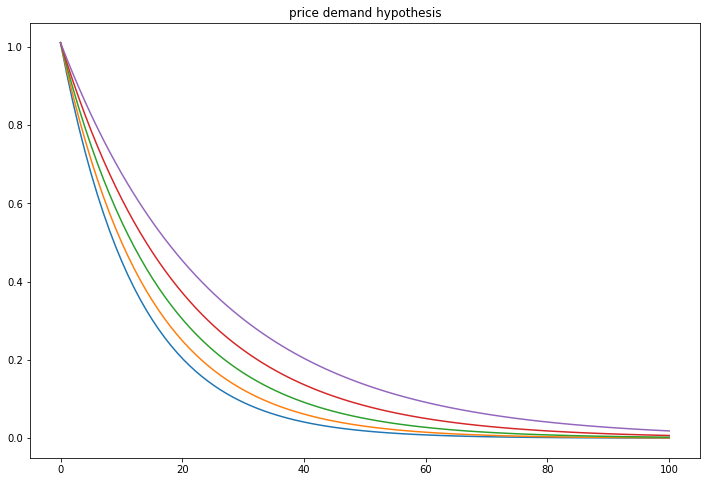

In [18]:
def log_linear_function(x,a,b):
    return np.exp(a + b * x)

x = np.linspace(0,100,100) # 100 linearly spaced numbers

plt.figure(figsize=(12,8)) # In this example, all the plots will be in one figure.    

for a in np.arange(0.01, 0.02, 0.01):
    for b in np.arange(-0.08, -0.03, 0.01):
        y = log_linear_function(x,a,b) # computing the values of sin(x)/x
        plt.plot(x, y, '-', label='Estimate')

plt.title("price demand hypothesis")
plt.show()

This is a simulation, where I do not get real data. Therefore I chose the "real" demand to be the function with a=0.01 and b=-0.04, which leads to an optimal price of about 25€. This is what our algorithm is supposed to find.

The idea is the following: we start with an initial price and we observe for a the real demand flowing in. We then calculate which of the candidate functions is most likely to be the best fit for the observed data. We calculate the optimal price for the best candidate function, set the new price and then observe the demand. The process is repeated for T times.

In [14]:
class PriceFinding:
    def __init__(self, T=30, m=3, initial_price=16, a_min=0.01, a_max=0.03, b_min=-0.08, b_max=-0.01, step_a=0.01, step_b=0.01, min_price=10, max_price=40):
        self.T=T
        self.m=m
        self.initial_price=initial_price
        self.a_min=a_min
        self.a_max=a_max
        self.b_min=b_min
        self.b_max=b_max
        self.step_a=step_a
        self.step_b=step_b
        self.min_price=min_price
        self.max_price=max_price
        
    def valid_init_price(self, initial_price):
        return self.min_price <= initial_price <= self.max_price
        
    def init_params(self):
        list_function_values=[]
        for a in np.arange(self.a_min, self.a_max, self.step_a):
            for b in np.arange(self.b_min, self.b_max, self.step_b):
                list_function_values.append((a,b))
        return list_function_values

    def log_linear_function_demand_(self,x,a,b):
        return -(x * (np.exp(a + b * x)))
    
    def calc_demand(self, p):
        list_demand=[]
        def log_linear_function_demand(x,a,b):
            return -(x * (np.exp(a + b * x)))
        for i in range(0, len(self.init_params())):
                a=self.init_params()[i][0]
                b=self.init_params()[i][1]
                temp_demand = -log_linear_function_demand(p,a,b)
                list_demand.append(temp_demand)
        return list_demand
    
    def calc_opt_p(self):
        list_p_opt=[]
        def log_linear_function_demand(x):
            return -(x * (np.exp(a + b * x)))
        for i in range(0, len(self.init_params())):
                a=self.init_params()[i][0]
                b=self.init_params()[i][1]
                res = minimize_scalar(log_linear_function_demand, method='bounded', bounds=(self.min_price, self.max_price))
                list_p_opt.append(res['x'])
        return list_p_opt 
    
    def sample_actual_demand(self, p, a=0.01, b=-0.04):
        return -self.log_linear_function_demand_(p,a,b)+np.random.normal(0,2,1)
    
    def make_mask(self):
        t_mask = np.array(range(0,round(self.T/self.m)))
        t_mask = np.repeat(t_mask, self.m)
        
        return t_mask
        
    def run_simulation(self):
        
        if not self.valid_init_price(self.initial_price):
            raise Exception(f' initial_price should be between min_preis({self.min_price}) and max_preis({self.max_price}). The value of initial_price was: {self.initial_price}')
         
        T = self.T                          # time step is month
        m = self.m                            # every 3 days

        tau = 0                                 # start time of the current interval

        p = self.initial_price

        t_mask = self.make_mask()
        
        hist_d = []
        
        price_trace=[]

        for t in range(0, T - 1):               # simulation loop
            realized_d = self.sample_actual_demand(p)

            hist_d.append(realized_d)
            price_trace.append(p)


            if( t_mask[t] != t_mask[t + 1] ):   # end of the interval
                interval_mean_d = np.mean( hist_d[tau : t + 1] )

                min_dist = float("inf")
                dist_hypothesis=[]
                index_price_hypothesis=[]

                demand_pred_by_func = self.calc_demand(p)
                for demand in demand_pred_by_func:
                    dist = abs(interval_mean_d - demand)
                    dist_hypothesis.append(dist)
                idx_price = np.argmin(dist_hypothesis)

                p = self.calc_opt_p()[idx_price]             # set price for the next interval
                tau = t + 1  
                
        return price_trace
    
    def make_plt(self):
        x = range(0,self.T-1)
        y = np.asarray(self.run_simulation())
        
        plt.figure(figsize=(12,8)) # In this example, all the plots will be in one figure.    
        for i in range(len(self.calc_opt_p())):
            plt.plot(x, y, '-', label='Estimate')
        plt.title("price finding")
        xcoords = np.arange(0,stop=self.T, step=self.m)
        for xc in xcoords:
            plt.axvline(x=xc)
        plt.grid()
        plt.ylim(0, 70)
        plt.show()
        

What the PriceFinding class is doing is the following. As arguments, we can pass any set of values we believe our correct demand function to be in. We can set the inital price, min_price, max_price and for how long we want to learn (T). Moreover, we can set the intervals between which the price should be fixed (m). 

init_params() is a method where we build a list of tuples for values a and b we set our candidate demand function to be of.
calc_demand() calculates for each of these combinations of a and b the demand for a given price.

cald_p_opt() calculates the optimal price for a given combination of a and b. We make use of the scipy.minimize_scalar function here.
sample_actual_demand is a helper function for our simulation which gives us the observed demand. In this case, I chose the "real" demand to have parameters a=0.01 and b=-0.04. To make it a bite more difficult, I added some random noise.

make_t_mask() returns an array counting up as soon as we come to the stage where we are allowed to change the price again (m).

run_simulation() is pretty self-explanatory. We start with the inital price for m time-slots, then observe the demand, calculate how far off every candidate function was, take the most suitable and use the optimal price from this candidate function. The process is repeatet until T.

make_plot() finally plots the price-trace.

In [19]:
p = PriceFinding(initial_price=14, T=30)

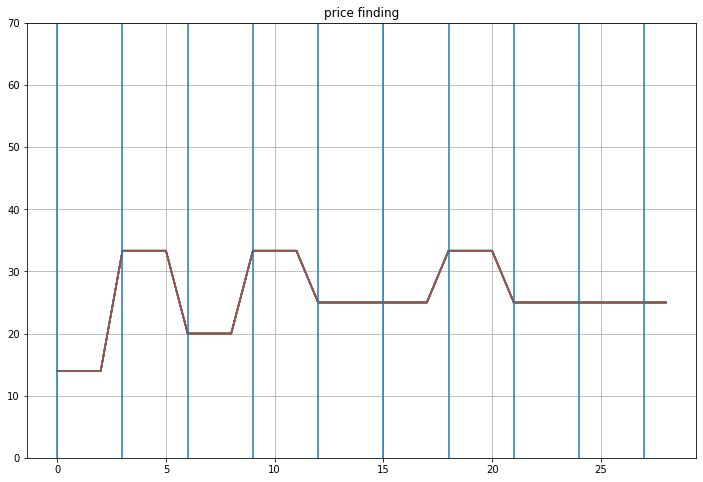

In [20]:
p.make_plt()